In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch import optim
import os
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from PIL import Image


import Unet as Unet

## Data Pre-Processing. Re-sizing and Transform Definitions

In [2]:
IMG_SIZE = 64
#IMG_SIZE = 32
BATCH_SIZE = 8

data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ]

data_transform = transforms.Compose(data_transforms)

reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

In [3]:
train = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)

test = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform, split='test')

data = torch.utils.data.ConcatDataset([train, test])
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
def show_tensor_image(Tensor):
    if len(Tensor.shape) == 4:
        Tensor = Tensor[0, :, :, :]
    plt.imshow(reverse_transforms(Tensor))


## Forward Diffusion Process

In [5]:
def prepare_noise_schedule(noise_steps, beta_start=0.0001, beta_end=0.02):
        return torch.linspace(beta_start, beta_end, noise_steps)

#### Parameters defined according to Nichol & Dariwal Paper (https://arxiv.org/pdf/2102.09672.pdf)

In [6]:
T = 300
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used is ", device)

s = 0.008
timesteps = torch.tensor(range(0, T), dtype=torch.float32)
schedule = torch.cos((timesteps / T + s) / (1 + s) * torch.pi / 2)**2
schedule = schedule.to(device)

alpha_hat = (schedule / schedule[0])
beta = 1 - alpha_hat / torch.concatenate([alpha_hat[0:1], alpha_hat[0:-1]])
alpha = 1 - beta

device used is  cuda


#### Diffusion Parameters defined according to Jo. et al (2020) (https://arxiv.org/pdf/2006.11239.pdf)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
T = 300
beta = prepare_noise_schedule(noise_steps=T).to(device)
print(beta.device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, axis=0)

cuda:0


In [8]:
def forward_diffusion_sample(x, t):
    noise = torch.randn_like(x)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

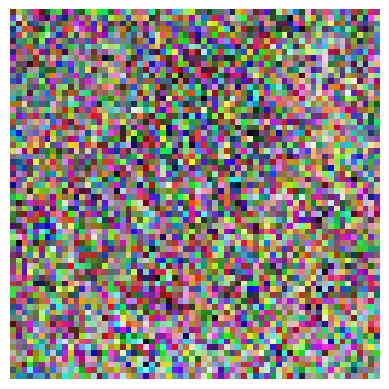

In [9]:
import PIL
import urllib

def get_sample_image()-> PIL.Image.Image:
    """
    Load a web .jpg file and return it as a PIL.Image.Image object.
    """
    url = 'https://www.bing.com/images/blob?bcid=ss.GqbQQMvgGyw'
    filename = 'cat.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

def load_local_image(filename: str) -> PIL.Image.Image:
    """
    Load a local .jpg image from the same directory as the notebook.
    """
    file_path = os.path.join(os.getcwd(), filename)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"El archivo '{filename}' no se encuentra en la misma carpeta.")
    
    pil_image = PIL.Image.open(file_path)
    
    return pil_image



#image = get_sample_image()
image = load_local_image("cat2.jpg")
image = data_transform(image)

t = torch.Tensor([100]).type(torch.int64) #Modify [t] to get diffusion on Image after t timesteps (Toy Example)

img, noise = forward_diffusion_sample(image.to(device), t.to(device))
show_tensor_image(img.cpu())

plt.axis('off')
plt.show()

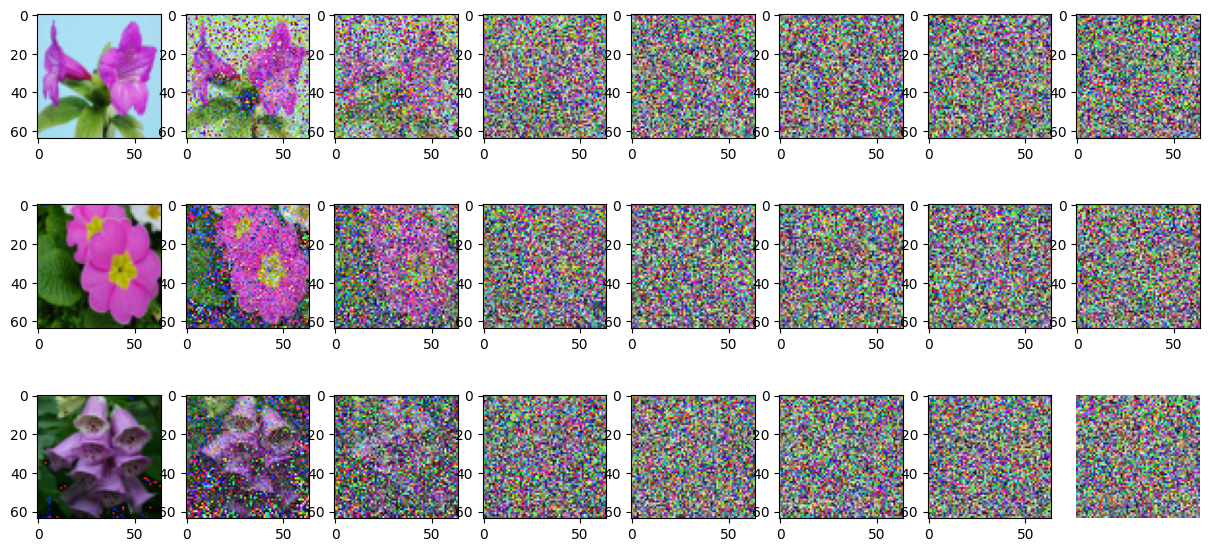

In [13]:
num_images = 3
num_steps = 7

plt.figure(figsize=(15,7)) 

for i in range(num_images):

    image = next(iter(dataloader))[0]
    stepsize = int(T/num_steps)
    
    for idx in range(0, T, stepsize):
        t = torch.Tensor([idx]).type(torch.int64)
        
        plt.subplot(num_images, num_steps+1, i*(num_steps+1) + int(idx/stepsize) + 1)
        
        img, noise = forward_diffusion_sample(image.to(device), t.to(device))
        show_tensor_image(img.cpu())

plt.axis('off')
plt.show()

## Model Instantiation

In [14]:
model = Unet.UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  23332739


## Sampling Algorithms

In [15]:
def sample_timesteps(n):
    return torch.randint(low=1, high=T, size=(n,))

### Stochastic Sampling, according to 2020 pp.

In [16]:
def sample(model, n):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(device) # X_T initialisation
        for i in tqdm(reversed(range(1, T)), position=0): # Sampling loop according to paper
            t = (torch.ones(n) * i).long().to(device)
            predicted_noise = model(x, t)
            alpha_t = alpha[t][:, None, None, None]
            alpha_hat_t = alpha_hat[t][:, None, None, None]
            beta_t = beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / (torch.sqrt(1 - alpha_hat_t))) * predicted_noise) + torch.sqrt(beta_t) * noise
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

### Deterministic Sampling, according to DDIM paper by Song et al. (https://arxiv.org/pdf/2010.02502.pdf)

In [17]:
def deterministic_sample(model, n, x=None):
    model.eval()
    with torch.no_grad():
        if x is None:
            x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(device) # X_T initialisation
        
        for i in tqdm(reversed(range(1, T)), position=0): # Sampling loop according to paper
            t = (torch.ones(n) * i).long().to(device)
            predicted_noise = model(x, t)
            alpha_hat_t = alpha_hat[t][:, None, None, None] 
            alpha_hat_t_minus_1 = alpha_hat[t-1][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
                
            else:
                noise = torch.zeros_like(x)
            x = torch.sqrt(alpha_hat_t_minus_1) * ((x - torch.sqrt(1 - alpha_hat_t) * predicted_noise)/(torch.sqrt(alpha_hat_t))) + torch.sqrt(1 - alpha_hat_t_minus_1) * predicted_noise
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

In [91]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

## Trainning 
#### ( I recommend not to train, just run the lines ahead this section, "Loading the Model")

In [34]:
def train(dataloader, args):
    device = args.device
    model = Unet.UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    for epoch in range(args.epochs):
        pbar = tqdm(dataloader) # Progression bar
        for i, (images, _) in enumerate(pbar): # Tuple (nEpoch, (images, _))
            images = images.to(device) 
            t = sample_timesteps(images.shape[0]).to(device) # Sample random t array
            x_t, noise = forward_diffusion_sample(images, t) # Sample (x_t, noise)
            predicted_noise = model(x_t, t) # Make a prediction
            loss = mse(noise, predicted_noise) # Calculate MSE loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Take gradient descent step

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        sampled_images = sample(model, n=images.shape[0])
        plot_images(sampled_images)
        save_images(sampled_images, os.path.join("results", f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", f"ckpt.pt"))

In [ ]:
os.makedirs(os.path.join("models"), exist_ok=True)
os.makedirs(os.path.join("results"), exist_ok=True)

In [ ]:
import argparse
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()
args.run_name = "DDPM"
args.epochs = 30
args.device = "cuda"
args.lr = 3e-4
train(dataloader, args)

## Loading the model

In [19]:
def load_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()  
    return model

checkpoint_path = "models/ckpt.pt"

model = Unet.UNet().to("cuda")

loaded_model = load_model(model, checkpoint_path)

### Stochastic Sampling

In [92]:
def plot_images2(images):
    plt.figure(figsize=(4, 4))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()



In [87]:
def samplePlot(model, n):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(device) # X_T initialisation
        for i in tqdm(reversed(range(1, T)), position=0): # Sampling loop according to paper
            t = (torch.ones(n) * i).long().to(device)
            predicted_noise = model(x, t)
            alpha_t = alpha[t][:, None, None, None]
            alpha_hat_t = alpha_hat[t][:, None, None, None]
            beta_t = beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / (torch.sqrt(1 - alpha_hat_t))) * predicted_noise) + torch.sqrt(beta_t) * noise

            if (i % 50 == 0 or i == 1):
                x2 = x
                x2 = (x2.clamp(-1, 1) + 1) / 2
                x2 = (x2 * 255).type(torch.uint8)
                plot_images2(x2)

    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

48it [00:00, 52.58it/s]

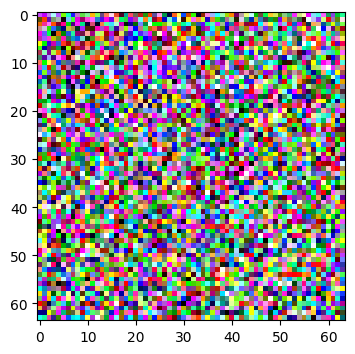

95it [00:01, 53.59it/s]

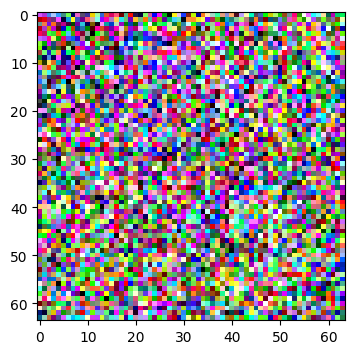

149it [00:02, 55.18it/s]

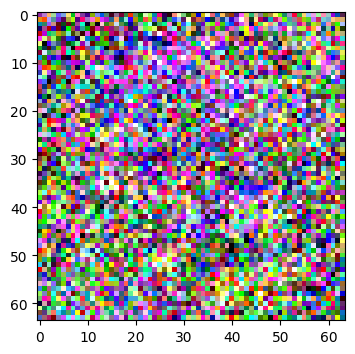

197it [00:03, 54.95it/s]

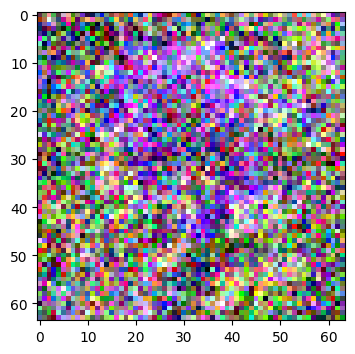

245it [00:04, 54.51it/s]

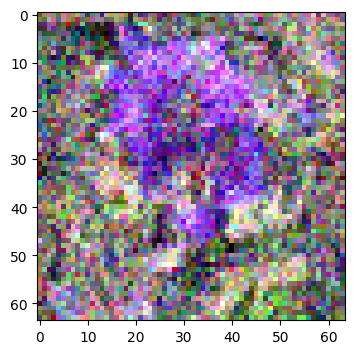

293it [00:05, 54.14it/s]

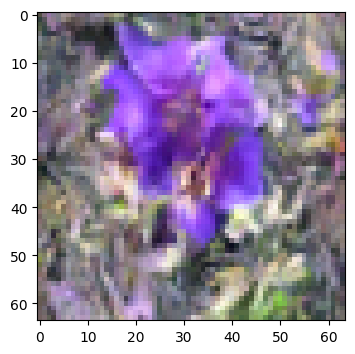

299it [00:05, 51.11it/s]


In [88]:
num_images_to_sample = 1  # Adjust this number as needed

sampled_images = samplePlot(loaded_model, num_images_to_sample)

#plot_images(sampled_images)

299it [00:23, 12.61it/s]


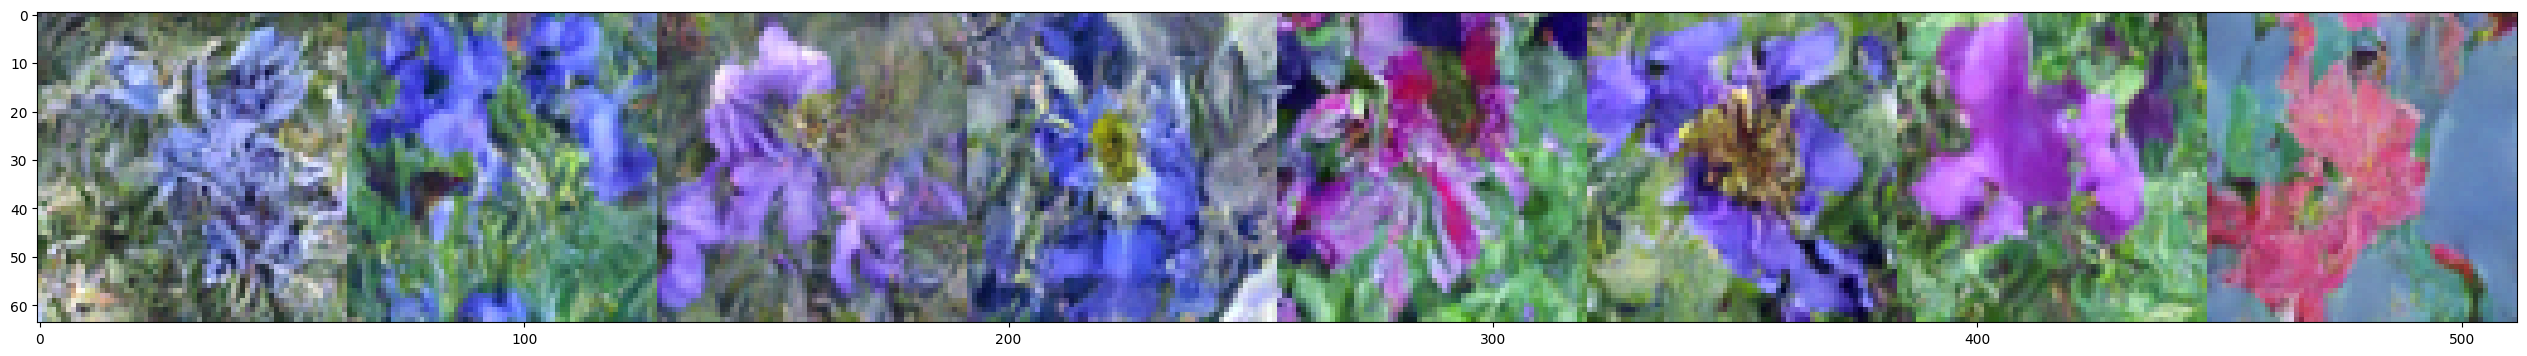

In [31]:
num_images_to_sample = 8  # Adjust this number as needed

sampled_images = sample(loaded_model, num_images_to_sample)

plot_images(sampled_images)

299it [00:25, 11.80it/s]


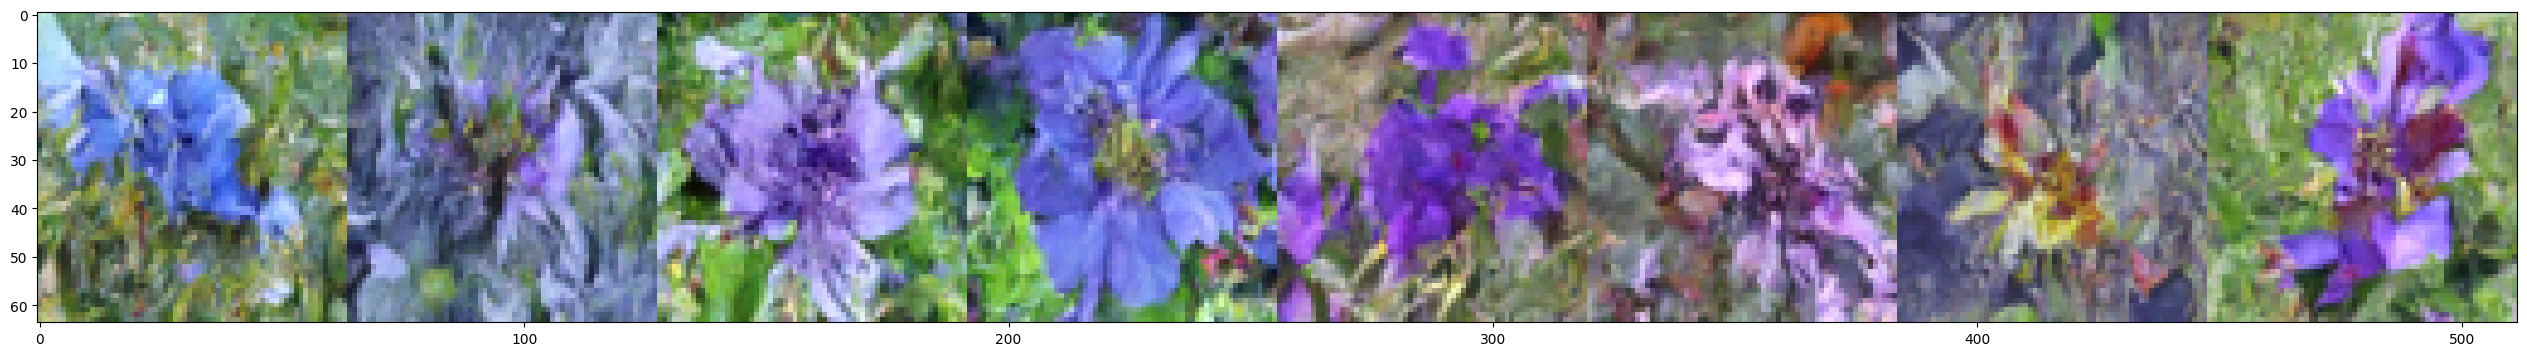

In [29]:
num_images_to_sample = 8  # Adjust this number as needed

sampled_images = sample(loaded_model, num_images_to_sample)

plot_images(sampled_images)

### Deterministic Sampling

In [28]:
num_images_to_sample = 10  # Adjust this number as needed

x = torch.randn((num_images_to_sample, 3, IMG_SIZE, IMG_SIZE)).to(device) # X_T initialisation

If I sample twice, from the same $x_T$, given I am using Deterministic sampling, I will get the same result:


299it [00:25, 11.57it/s]


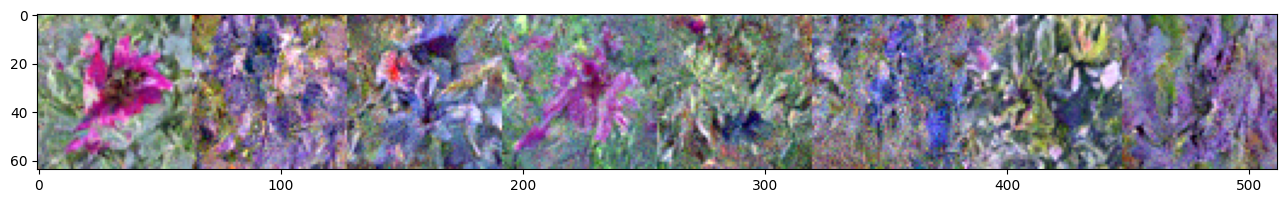

In [89]:
sampled_images = deterministic_sample(loaded_model, num_images_to_sample, x=x)

plot_images(sampled_images)

299it [00:25, 11.77it/s]


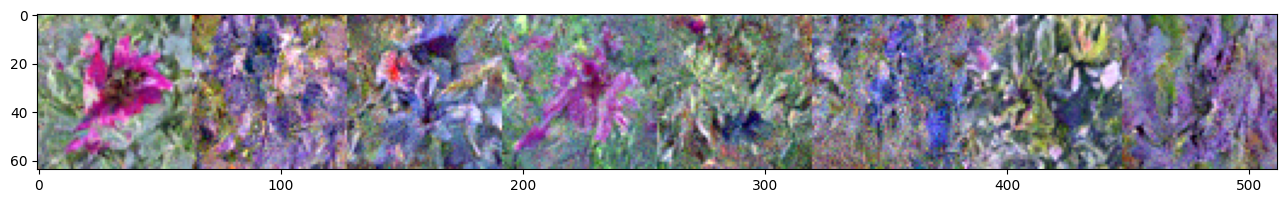

In [90]:
sampled_images = deterministic_sample(loaded_model, num_images_to_sample, x=x)

plot_images(sampled_images)